# Raster Processing

The goal of this lecture is to learn how to do reprojections and mosaicking of rasters in Python. We will use `rioxarray` as the main package for these tasks. 

## Reprojecting a Raster File

If you work with more than one type of raster data, it is very common that you need to reproject them to the same CRS. There are various ways to do this using methods in `rasterio` which are also available in `rioxarray`. 

In this section, our goal is to reporject a Sentinel-2 scene to the USDA Crop Data Layer (CDL) CRS. [USDA CDL](https://www.nass.usda.gov/Research_and_Science/Cropland/SARS1a.php) is a national map of croplands (some generic land cover classes) which USDS generates every year. This dataset is shared in a single GeoTIFF file for the Contiguous United States (CONUS). 

In [1]:
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import numpy as np
import pyproj
from rasterio.enums import Resampling
import leafmap
import os
import requests
import tqdm

In [2]:
def download_file(url, local_path):
    """
    This function downloads a file from the web to a local path. 

    Inputs:
    url : string
        A public URL to the file on the web
    local_path : string
        A path to a local directory where the file should be downloaded. This should include the file name. 

    Return:
    None

    """
    if not os.path.exists(local_path):
        print(f"File not found locally. Downloading from {url}...")
        
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Check if the request was successful
            
            with open(local_path, "wb") as file:
                for chunk in tqdm.tqdm(response.iter_content()):
                    file.write(chunk)
            print("Download complete.")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
    else:
        print("File already exists locally. No download needed.")

In the following, we will use a Sentinel-2 scene available on AWS S3. We have already queried the Earth Search STAC API and retrieved the URL for the COG file of the scene:

In [3]:
s2_scene_path = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/CG/2023/10/S2A_19TCG_20231026_0_L2A/B04.tif'

We also need to retrieve the USDA CDL data. This is available [here](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php), and in the following we donwload and unzip the data locally. Loading this file into memory is not feasible on a personal machine or servers with regular memory capacity.

In [4]:
local_path = "/home/gisuser/"

In [5]:
if not os.path.exists(local_path + "data/"):
    os.mkdir(local_path + "data/")
else:
    print("Data folder already exists")

Data folder already exists


In [6]:
download_file(
    "https://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/2022_30m_cdls.zip", 
    f"{local_path}/data/2022_30m_cdls.zip"
)

File already exists locally. No download needed.


Now, let's open the CDL file. We will use the `cache=False` argument to not load the data into memory, rather read the metadata. 

In [7]:
import zipfile
with zipfile.ZipFile(f"{local_path}/data/2022_30m_cdls.zip","r") as zip_ref:
    zip_ref.extractall(f"{local_path}/data/")

In [8]:
cdl_file = f"{local_path}/data/2022_30m_cdls.tif"
cdl_ds = rxr.open_rasterio(cdl_file, cache=False)

In [9]:
cdl_ds

<xarray.DataArray (band: 1, y: 96523, x: 153811)> Size: 15GB
[14846299153 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 772kB 3.173e+06 3.173e+06 ... 2.77e+05 2.769e+05
  * x            (x) float64 1MB -2.356e+06 -2.356e+06 ... 2.258e+06 2.258e+06
    spatial_ref  int64 8B 0
Attributes: (12/22)
    TIFFTAG_SOFTWARE:           E
    TIFFTAG_XRESOLUTION:        1
    TIFFTAG_YRESOLUTION:        1
    TIFFTAG_RESOLUTIONUNIT:     2 (pixels/inch)
    AREA_OR_POINT:              Area
    LAYER_TYPE:                 thematic
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          56.056102758529
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

Next, we define functions that are needed for reprojection:

In [10]:
def point_transform(coor, src_crs, target_crs=5070):
    """
    This function transforms a coordinate (x, y) from a source crs to a target crs. 
    
    Inputs:
        coor : list
        a list or tuple containing the coordinates in x, y format. 
        src_crs : `proj4` CRS
            The source CRS of the coordinate (it should be in a format known to `proj4`)
        target_crs : `proj4` CRS
            The target CRS for transforming the coordinate. Default is `EPSG:5070` which is the CRS of USDA CDL data.
    
    Return:
        transformed_coor : list
            A list with the transformed coordinates in x, y format. 
    """
    
    proj = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    projected_coor = proj.transform(coor[0], coor[1])
    transformed_coor = [projected_coor[0], projected_coor[1]]
    
    return transformed_coor

def find_nearest(array, value):
    """
    This function returns the closet number to `value` in the `array`.

    Inputs:
        array : numpy array
            An array 
        value : numpy array
            The value to search for nearest in the `array`. 

    Returns
        target : numpy array
            The number closes to the `value` in the `array`
    
    """
    
    idx = (np.abs(array - value)).argmin()
    target = array[idx]
    
    return target


def reproject_s2_to_cdl(tile_path,
                        cdl_ds,
                        resampling_method = Resampling.bilinear):
    
    """
    This function receives the path to a Sentinel-2 scene and reproject it to the target cdl_ds.
    
    Inputs:
        tile_path : string
            The full path to a sentinel-2 scene. This can be the url to an object on the cloud store. 
        cdl_ds : rioxarray dataset
            A rioxarray dataset that is opened with `cache=False` settings
        resampling_method : rasterio resampling method
            The method that rioxarray uses to reproject, default is bilinear. The method should be imported from rasterio.
    
    Returns:
       xds_new : rioxarray dataset
           The reprojected tile in rioxarray dataset format
    """

    s2_ds = rxr.open_rasterio(tile_path)
    
    half_scene_len = np.abs(np.round((s2_ds.x.max().data - s2_ds.x.min().data) / 2))
    
    coor_min = point_transform([s2_ds.x.min().data - half_scene_len, s2_ds.y.min().data - half_scene_len], s2_ds.rio.crs)
    coor_max = point_transform([s2_ds.x.max().data + half_scene_len, s2_ds.y.max().data + half_scene_len], s2_ds.rio.crs)
    
    x0 = find_nearest(cdl_ds.x.data, coor_min[0])
    y0 = find_nearest(cdl_ds.y.data, coor_min[1])
    x1 = find_nearest(cdl_ds.x.data, coor_max[0])
    y1 = find_nearest(cdl_ds.y.data, coor_max[1])
    
    cdl_for_reprojection = cdl_ds.rio.slice_xy(x0, y0, x1, y1)
    
    xds_new = s2_ds.rio.reproject_match(cdl_for_reprojection, resampling = resampling_method)
    
    return xds_new



In [11]:
s2_nearest = reproject_s2_to_cdl(
    s2_scene_path,
    cdl_ds,
    resampling_method = Resampling.nearest
)

In [12]:
s2_nearest.rio.to_raster("s2_nearest.tif")

In [13]:
s2_bilinear = reproject_s2_to_cdl(
    s2_scene_path,
    cdl_ds,
    resampling_method = Resampling.bilinear
)

In [14]:
s2_bilinear.rio.to_raster("s2_bilinear.tif")

Inspect the reprojected scenes in QGIS, and explain the differences between the two methods and the differences between the reprojected scenes and the original scene. 

## Using `rioxarray` with Dask

In this section, we will review how to use Dask with `rioxarray` to improve reading COG files. For maximum read performance, the chunking pattern you request with `rio.open_rasterio` should align with the internal chunking of the COG. Typically this means reading the data in a “row major” format: your chunks should be as wide as possible along the columns. (Check out [this page](https://corteva.github.io/rioxarray/html/examples/read-locks.html) for more information about this)

Let's try this on a sample scene to read the raster, and calculate the mean value. We have a sample scene from green band of Sentinel-2 available on AWS S3:

In [15]:
import dask 
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [16]:
sample_scene = "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/CF/2023/10/S2A_19TCF_20231026_0_L2A/B03.tif"

First, we use `rioxarray` without Dask:

In [17]:
%%timeit -n 1 -r 1
green_band = rxr.open_rasterio(sample_scene)
green_band.mean()

11.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now, let's add Dask. 

In [18]:
%%timeit -n 1 -r 1
green_band_dask = rxr.open_rasterio(sample_scene, chunks=(1, 'auto', -1))
green_band_dask.mean().compute()

13.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%%timeit -n 1 -r 1
green_band_dask = rxr.open_rasterio(sample_scene, lock=False, chunks=(1, 'auto', -1))
green_band_dask.mean().compute()

22.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Mosaicking Rasters

Let's say you are interested in generating an RGB image of Sentinel-2 across your area of interest defined in the following `aoi_box`.

In [20]:
from shapely.geometry import box
import shapely
import json

In [21]:
aoi_box = box(-70.74295109234716, 41.01426426532743, -69.46303157927986, 42.0218426094371)

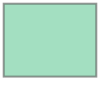

In [22]:
aoi_box

First, let's visualize this `bbox`. To use this in leafmap, we need to convert it to a GeoJSON FeatureCollection:

In [23]:
def geojson_featurecollection(geom):
    """
    This function converts a GeoJSON feature to a GeoJSON FeatureCollection, and return a dictionary.

    Inputs:
    geom : GeoJSON feature (str or dict)
        A python dictionary containing the feature in string format or dictionary. 
        
    Return:
    geojson_dict : dict
        A GeoJSON FeatureCollection dictionary

    """
    if isinstance(geom, str):
        geom = json.loads(geom)
        
    geojson_dict = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "geometry": geom,
            "properties": {}
        }]
    }

    return geojson_dict

In [24]:
m = leafmap.Map(center=[41.633484, -70.154371], zoom=8, height="500px")
m.add_geojson(geojson_featurecollection(shapely.to_geojson(aoi_box)))
m

Map(center=[41.633484, -70.154371], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

We use the `PySTAC` client to search for imagery across this area:

In [25]:
import pystac_client
import planetary_computer

def retrieve_stac_items_bbox(url, collection, bbox, max_items = 10, pc_flag = False, query = None): 
    """
    This function retrieves the latest STAC items from a STAC API
    
    Parameters
    ----------
    url : str
        The STAC API URL
    collection : str
        Collection ID to search in the STAC API
    bbox : dict
       A tuple or list with coordinates of the target area for API search in the format (min x, min y, max x, max y)
    pc_flag : boolean
        A boolean flag to specify whether the STAC API is Microsoft's planetary computer API. Default is set to False.
    query : list
        A list of query parameters for STAC API. Default is set to None. 
    max_items: integer
        Maximum number of items to retrieve from the STAC API. Default is 1. 

    Returns
    -------
    items : Generator
        The STAC item that has the latest date of acquisition given all the query parameters. 
        
    """
    if pc_flag:
        modifier = planetary_computer.sign_inplace
    else:
        modifier = None
        
    catalog = pystac_client.Client.open(
        url = url,
        modifier = modifier,
    )

    search_results = catalog.search(
        collections = [collection],
        bbox = bbox,
        query = query,
        sortby = ["-properties.datetime"],
        max_items = max_items
    )
    items = search_results.item_collection()

    return items

In [26]:
items = retrieve_stac_items_bbox(url = "https://earth-search.aws.element84.com/v1",
                                collection = "sentinel-2-l2a",
                                bbox = aoi_box.bounds,
                                max_items = 4,
                                pc_flag = False,
                                query = ["s2:nodata_pixel_percentage<1"]
                                )

In [27]:
for item in items:
    m.add_geojson(geojson_featurecollection(item.geometry), style = {"color": "red"})
m

Map(bottom=24668.0, center=[41.633484, -70.154371], controls=(ZoomControl(options=['position', 'zoom_in_text',…

So, as we can see in the map there are four scenes that overlap with our area of interest. We need to mosaick the overlapping Sentinel-2 scenes to generate one raster. 

We will use `merge_datasets` from `rioxarray`

In [28]:
def gen_stac_asset_urls(items, asset):
    """
    This function receives an items collection returned by a STAC API, and returns
    the urls of the requested `asset` in a list. 

    Inputs:
        items : json collection
            A STAC items collection returned by STAC API
        asset : string
            Name of an asset present in the `items` collection

    Returns:
        urls : list
            List of all usls related to the `asset`
            
    """
    
    urls = []
    for item in items:
        urls.append(item.assets[asset].href)
    
    return urls

In [29]:
red_urls = gen_stac_asset_urls(items, "red")
green_urls = gen_stac_asset_urls(items, "green")
blue_urls = gen_stac_asset_urls(items, "blue")

In [30]:
blue_urls

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/CF/2025/10/S2C_19TCF_20251025_0_L2A/B02.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/DF/2025/10/S2C_19TDF_20251025_0_L2A/B02.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/CG/2025/10/S2C_19TCG_20251025_0_L2A/B02.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/DG/2025/10/S2C_19TDG_20251025_0_L2A/B02.tif']

In [31]:
temp_dataarray = rxr.open_rasterio(red_urls[0])

In [32]:
temp_dataset = rxr.open_rasterio(red_urls[0]).to_dataset(name="red")

In [33]:
temp_dataarray

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 88kB 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [34]:
temp_dataset

<xarray.Dataset> Size: 241MB
Dimensions:      (band: 1, x: 10980, y: 10980)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) uint16 241MB ...

In [35]:
red_datasets = [
    rxr.open_rasterio(url, lock=False, chunks=(1, 'auto', -1)).to_dataset(name="red") for url in red_urls
]

In [36]:
red_datasets[0]

<xarray.Dataset> Size: 241MB
Dimensions:      (band: 1, x: 10980, y: 10980)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) uint16 241MB dask.array<chunksize=(1, 6111, 10980), meta=np.ndarray>

In [37]:
mosaic_red = merge_datasets(red_datasets)

In [38]:
mosaic_red.red.rio.to_raster("red_mosaic.tif")

In [39]:
mosaic_red = mosaic_red.rio.clip([aoi_box], crs=4326)

In [40]:
mosaic_red.red.rio.to_raster("red_clipped.tif")

In [41]:
green_datasets = [
    rxr.open_rasterio(url, lock=False, chunks=(1, 'auto', -1)).to_dataset(name="green") for url in green_urls
]

In [42]:
blue_datasets = [
    rxr.open_rasterio(url, lock=False, chunks=(1, 'auto', -1)).to_dataset(name="blue") for url in blue_urls
]

In [43]:
mosaic_blue = merge_datasets(blue_datasets)
mosaic_blue = mosaic_blue.rio.clip([aoi_box], crs=4326)

In [44]:
mosaic_green = merge_datasets(green_datasets)
mosaic_green = mosaic_green.rio.clip([aoi_box], crs=4326)

In [45]:
xr.merge([mosaic_red, mosaic_green, mosaic_blue])

<xarray.Dataset> Size: 735MB
Dimensions:      (x: 10823, y: 11323, band: 1)
Coordinates:
  * x            (x) float64 87kB 3.534e+05 3.535e+05 ... 4.617e+05 4.617e+05
  * y            (y) float64 91kB 4.654e+06 4.654e+06 ... 4.54e+06 4.54e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    green        (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    blue         (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [46]:
rgb = xr.merge([mosaic_red, mosaic_green, mosaic_blue])

In [47]:
rgb

<xarray.Dataset> Size: 735MB
Dimensions:      (x: 10823, y: 11323, band: 1)
Coordinates:
  * x            (x) float64 87kB 3.534e+05 3.535e+05 ... 4.617e+05 4.617e+05
  * y            (y) float64 91kB 4.654e+06 4.654e+06 ... 4.54e+06 4.54e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    green        (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    blue         (band, y, x) uint16 245MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0